In [7]:

from pgmpy.models import BayesianModel
from pgmpy.estimators import BayesianEstimator
import networkx as nx
import matplotlib.pyplot as plt
import graphviz
import pandas as pd
%matplotlib inline

#### Building a DAG (based on the transport model)

![](survey.png)

1a) factorization of the joint distribution:
    
P(A, S, E, O, R, T) = P(A)P(S)P(E|A, S)P(R|E)P(O|E)P(T| R, O)

1b, c)

In [2]:
transport_model = BayesianModel([('Age', 'Education'), 
                                 ('Sex', 'Education'),
                                 ('Education', 'Occupation'),
                                 ('Education', 'Resident'),
                                 ('Occupation', 'Transport'),
                                 ('Resident', 'Transport')
                                ])

1d)

In [3]:
transport_model

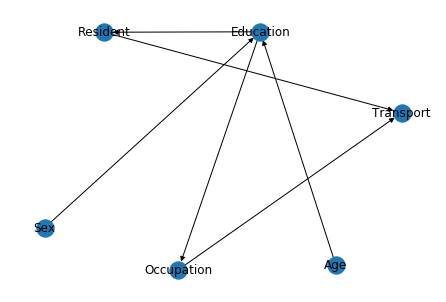

In [31]:
nx.draw_spring(transport_model, with_labels=True)
plt.show()

2a)

In [10]:
transport_model.nodes

NodeView(('Age', 'Education', 'Sex', 'Occupation', 'Resident', 'Transport'))

In [11]:
transport_model.edges

OutEdgeView([('Age', 'Education'), ('Education', 'Occupation'), ('Education', 'Resident'), ('Sex', 'Education'), ('Occupation', 'Transport'), ('Resident', 'Transport')])

2b)

In [8]:
for node in transport_model.nodes:
    print(f"node: {node}, parents: {transport_model.get_parents(node)}, children: {transport_model.get_children(node)}")

node: Age, parents: [], children: ['Education']
node: Education, parents: ['Age', 'Sex'], children: ['Occupation', 'Resident']
node: Sex, parents: [], children: ['Education']
node: Occupation, parents: ['Education'], children: ['Transport']
node: Resident, parents: ['Education'], children: ['Transport']
node: Transport, parents: ['Occupation', 'Resident'], children: []


2c)

In [9]:
#Markov blanket of 'A'
transport_model.get_markov_blanket('Age')

['Sex', 'Education']

In [10]:
#Markov blanket of 'E'
transport_model.get_markov_blanket('Education')

['Occupation', 'Sex', 'Age', 'Resident']

In [11]:
#Markov blanket of 'T'
try:
    transport_model.get_markov_blanket('Transport')
except KeyError as e:
    print(f"Transport has no markov blanket")

Transport has no markov blanket


2d) For each node, it's markov blanket are the set of nodes which if you know the values of (so they are fixed and no longer probabilities), then that node is independent of all the other nodes in the network

3a)

In [15]:
data = pd.read_csv('survey2.txt', sep=" ")
data = data.rename(columns={"A": "Age", "R": "Resident", "E": "Education",  "O":"Occupation",
                            "S": "Sex", "T" :"Transport"})



In [16]:
def create_and_fit_model(data, estimator, equivalent_sample_size):
    transport_model = BayesianModel([('Age', 'Education'), 
                                 ('Sex', 'Education'),
                                 ('Education', 'Occupation'),
                                 ('Education', 'Resident'),
                                 ('Occupation', 'Transport'),
                                 ('Resident', 'Transport')
                                ])
    transport_model.fit(data, estimator=estimator, equivalent_sample_size=equivalent_sample_size)
    return transport_model

3b)

In [17]:
equivalent_sample_sizes = [1,10, 20, 100]
for sz in equivalent_sample_sizes:
    model =  create_and_fit_model(data, BayesianEstimator, sz)
    nodes = ['Age', 'Education', 'Sex', 'Occupation', 'Resident', 'Transport']
    print('equivalent_sample_sizes/iss:', sz)
    for node in nodes:
        
        print(model.get_cpds(node))

equivalent_sample_sizes/iss: 1
+------------+----------+
| Age(adult) | 0.357539 |
+------------+----------+
| Age(old)   | 0.157842 |
+------------+----------+
| Age(young) | 0.484619 |
+------------+----------+
+-----------------+---------------------+---------------------+--------------------+---------------------+---------------------+---------------------+
| Age             | Age(adult)          | Age(adult)          | Age(old)           | Age(old)            | Age(young)          | Age(young)          |
+-----------------+---------------------+---------------------+--------------------+---------------------+---------------------+---------------------+
| Sex             | Sex(F)              | Sex(M)              | Sex(F)             | Sex(M)              | Sex(F)              | Sex(M)              |
+-----------------+---------------------+---------------------+--------------------+---------------------+---------------------+---------------------+
| Education(high) | 0.6389365351

4a)

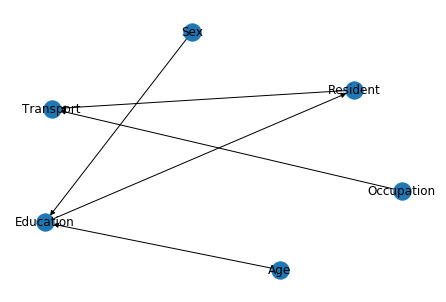

In [22]:
transport_model2 = transport_model.copy()
transport_model2.remove_edge('Education', 'Occupation')
nx.draw(transport_model2, with_labels=True)


4b)

In [25]:
equivalent_sample_sizes = 5
transport_model2.fit(data, estimator=BayesianEstimator)
transport_model.fit(data, estimator=BayesianEstimator)
nodes = ['Age', 'Education', 'Sex', 'Occupation', 'Resident', 'Transport']

for node in nodes:
    print(node)
    print('original')
    print(transport_model.get_cpds(node))
    print('updated ')
    print(transport_model2.get_cpds(node))

Age
original
+------------+----------+
| Age(adult) | 0.357393 |
+------------+----------+
| Age(old)   | 0.158897 |
+------------+----------+
| Age(young) | 0.483709 |
+------------+----------+
updated 
+------------+----------+
| Age(adult) | 0.357393 |
+------------+----------+
| Age(old)   | 0.158897 |
+------------+----------+
| Age(young) | 0.483709 |
+------------+----------+
Education
original
+-----------------+---------------------+--------------------+---------------------+---------------------+---------------------+---------------------+
| Age             | Age(adult)          | Age(adult)         | Age(old)            | Age(old)            | Age(young)          | Age(young)          |
+-----------------+---------------------+--------------------+---------------------+---------------------+---------------------+---------------------+
| Sex             | Sex(F)              | Sex(M)             | Sex(F)              | Sex(M)              | Sex(F)              | Sex(M)       

The local distributions are all unchanged except for that of the 'Occupation' node

Original factorisation is:
P(A, S, E, O, R, T) = P(A)P(S)P(E|A, S)P(R|E)P(O|E)P(T| R, O)

New factorisation is:
P(A, S, E, O, R, T) = P(A)P(S)P(E|A, S)P(R|E)P(O)P(T| R, O)

So the 'O' node had it's distribution changed from one that is dependent on E to one that isn't. As expected, the distributions on the other nodes hasn't changed as we can see that the factorisation hasn't changed.

In [ ]:
def pyro_model(observed_y):
    age = pyro.sample("Age", dist.Categorical(torch.tensor([0.48, 0.36, 0.16]))) #young, adult, old
    sex = pyro.sample("Sex",  dist.Categorical(torch.tensor([0.45, 0.55 ]))) # male, female
    
    education_probs = torch.tensor([[0.16,  0.81, 0.64,  0.72, 0.84, 0.89], [0.84,0.19, 0.36, 0.28, 0.16, 0.11]]) # ed=high, uni
    education = pyro.sample("Age", dist.Categorical(education_probs[age][sex]))
    
    john_probs = torch.tensor([[0.95, 0.05], [0.1, 0.9]])
    mary_probs = torch.tensor([[0.99, 0.01], [0.3, 0.7]])
    john_calls = pyro.sample("J", dist.Categorical(john_probs[alarm]))
    mary_calls = pyro.sample("M", dist.Categorical(mary_probs[alarm]))
